### Intermediate Step
We executed a necessary step for the analysis/modeling sequence.


In [1]:

# PredictThyroid – Model Comparison Notebook

<img src="images/Thyroid.png" alt="Image About Thyroid" width="200" height="300">

## Thyroid dataset:

./datasets/thyroid.csv


# Questions:

4.	Create a Jupyter notebook that includes the following: 
    * a. All the EDA operation to understand the data including descriptive statistics and at least 8–10 visualizations. 
    * b. Each analysis must have explanation regarding what inference you get from the data.
5.	Each block of code on your Jupyter notebook must have explanations.
6.	Answer the following questions in your notebook:
    * a. What is the Pearson correlation coefficient? 
    * b. How is each attribute important for predicting the target (heat map)?
    * c. What is k-fold cross-validation?
    * d. Why is the training dataset 70–80%? Why is the test dataset 20–30%?

- Preprocessing with ColumnTransformer (numeric/categorical)
- Stratified split
- 3 models: Logistic Regression, Random Forest and XGBoost (fallback to Gradient Boosting)
- Metrics (Accuracy, Precision, Recall, F1, ROC-AUC), confusion matrices, ROC curves
- Generates `predictThyroid_model_report.csv`

In [2]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils.multiclass import type_of_target

try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False
    print("XGBoost not available, using GradientBoostingClassifier as fallback.")


### Data Loading/Integration
We read the datasets and unified them into a single DataFrame for analysis.


In [3]:

# Target config and CSV detection
TARGET_NAME = None  # set manually if auto-detection fails

candidate_paths = [
    './datasets/thyroid.csv'
  ]

csv_path = None
for p in candidate_paths:
    if os.path.exists(p):
        csv_path = p
        break

if csv_path is None:
    raise FileNotFoundError("Place the CSV as 'predictThyroid.csv'/'thyroid.csv' in the notebook directory or in /mnt/data/.")

print(f"Using dataset at: {csv_path}")
df = pd.read_csv(csv_path)
print("Shape:", df.shape)
display(df.head())

if TARGET_NAME is None:
    common_targets = ['Outcome','outcome','target','Target','class','Class','label','Label','diagnosis','Diagnosis','y','Y']
    found = [c for c in df.columns if c in common_targets]
    if len(found) >= 1:
        TARGET_NAME = found[0]
        print("Auto-detected target:", TARGET_NAME)
    else:
        # Heuristic fallback: prefer small-cardinality columns (2..10 unique)
        candidates = []
        for c in df.columns:
            try:
                nuniq = df[c].nunique(dropna=True)
            except Exception:
                continue
            if 2 <= nuniq <= 10:
                candidates.append((c, nuniq))
        if candidates:
            candidates.sort(key=lambda x: x[1])
            TARGET_NAME = candidates[0][0]
            print("Heuristic target (small cardinality):", TARGET_NAME)
        else:
            TARGET_NAME = df.columns[-1]
            print("Fallback target (last column):", TARGET_NAME)

# Bind the chosen target name to TARGET for downstream cells
TARGET = TARGET_NAME or "Recurred"
print("Using target column: " + str(TARGET))


Using dataset at: ./datasets/thyroid.csv
Shape: (383, 17)


,Age,Gender,Smoking,Hx Smoking,Hx Radiothreapy,Thyroid Function,Physical Examination,Adenopathy,Pathology,Focality,Risk,T,N,M,Stage,Response,Recurred
0,27,F,No,No,No,Euthyroid,Single nodular goiter-left,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Indeterminate,No
1,34,F,No,Yes,No,Euthyroid,Multinodular goiter,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
2,30,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
3,62,F,No,No,No,Euthyroid,Single nodular goiter-right,No,Micropapillary,Uni-Focal,Low,T1a,N0,M0,I,Excellent,No
4,62,F,No,No,No,Euthyroid,Multinodular goiter,No,Micropapillary,Multi-Focal,Low,T1a,N0,M0,I,Excellent,No


Heuristic target (small cardinality): Gender
Using target column: Gender


**Note:** Define your main DataFrame as `df` (or adjust the safe heatmap block below).

In [4]:
# Try to bind your main DataFrame to `df` if it's named differently.
if 'df' not in globals():
    for cand in ['data', 'df_main', 'dataset', 'thyroid_df']:
        if cand in globals():
            df = globals()[cand]
            break

C:\Users\romil\AppData\Local\Temp\ipykernel_2132\99098299.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(groups, labels=labels)


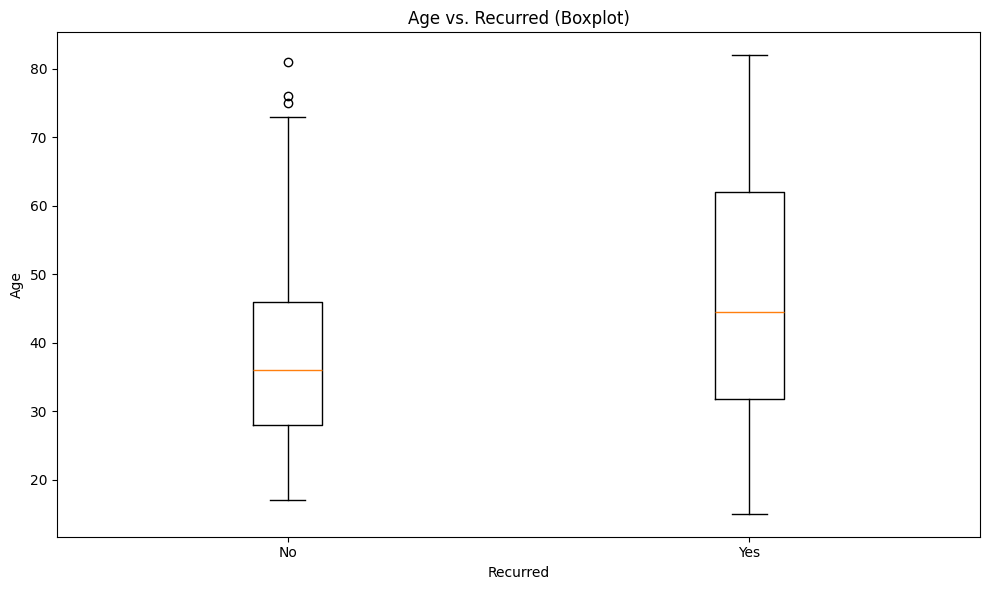

In [5]:
# compare age vs recurred with boxplot
classes = df['Recurred'].dropna().unique()
groups = [df.loc[df['Recurred'] == cls, 'Age'].dropna().astype(float) for cls in classes]
labels = classes.astype(str)
fig = plt.figure(figsize=(10, 6))
plt.boxplot(groups, labels=labels)
plt.title('Age vs. Recurred (Boxplot)')
plt.xlabel('Recurred')
plt.ylabel('Age')
plt.tight_layout()
plt.show()

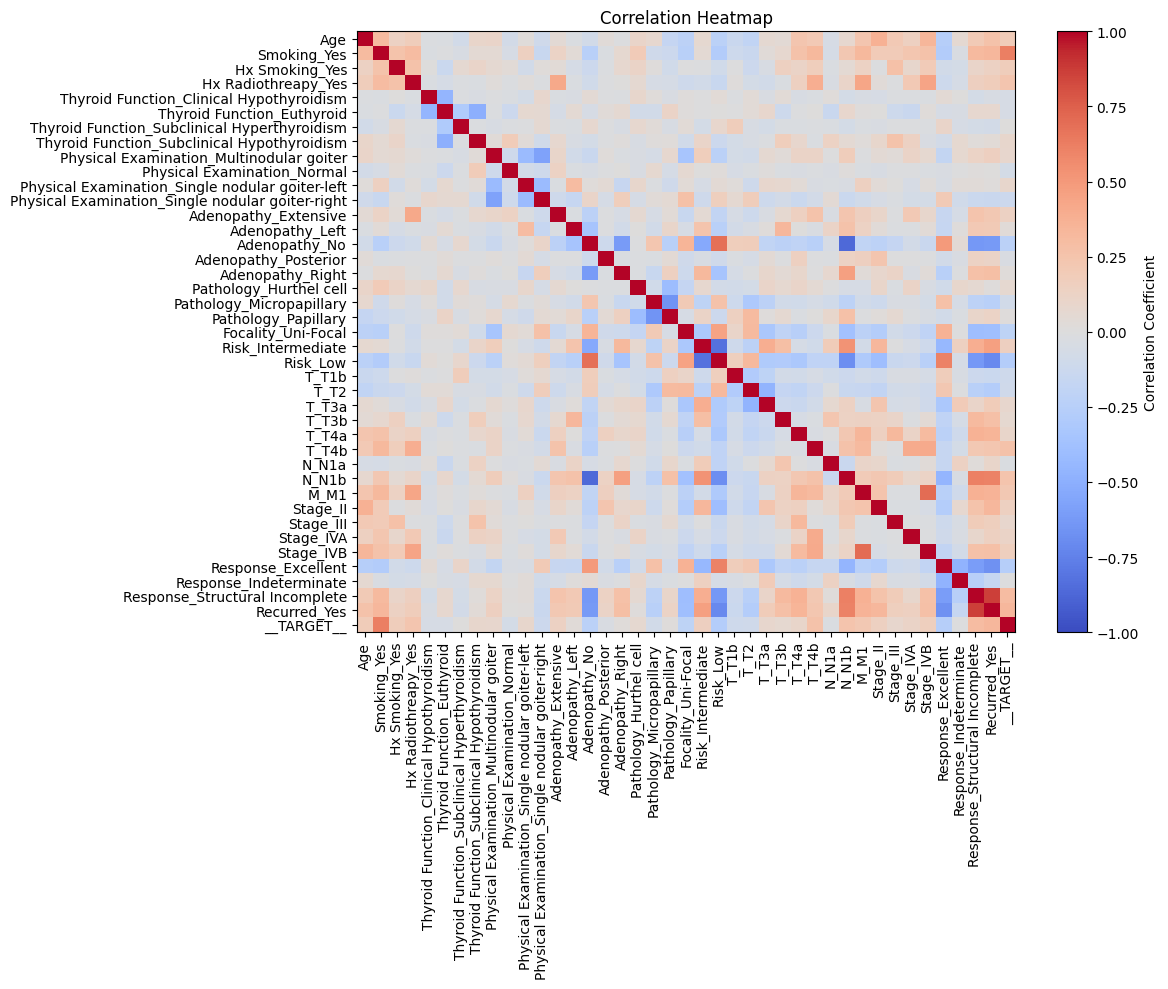

In [6]:
# one-hot encode categorical features and convert to numeric (0/1)
df_work = df.copy()

# encode target to binary codes for correlation analysis
y_codes = df_work[TARGET].astype('category').cat.codes

X = df_work.drop(columns=[TARGET])
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
X_cat_ohe = ohe.fit_transform(X[cat_cols]) if len(cat_cols) > 0 else np.empty((X.shape[0], 0))
X_num = X[num_cols].to_numpy() if len(num_cols) > 0 else np.empty((X.shape[0], 0))

X_all = np.hstack([X_num, X_cat_ohe])
feature_names = num_cols + ohe.get_feature_names_out(cat_cols).tolist()

# build a DataFrame including target for correlation analysis
df_corr = pd.DataFrame(X_all, columns=feature_names)
df_corr['__TARGET__'] = y_codes.values
corr = df_corr.corr(method='pearson')

# plot correlation heatmap
fig = plt.figure(figsize=(12, 10))
plt.imshow(corr, aspect='auto', cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')
plt.xticks(ticks=np.arange(len(corr.columns)), labels=corr.columns, rotation=90)
plt.yticks(ticks=np.arange(len(corr.index)), labels=corr.index)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

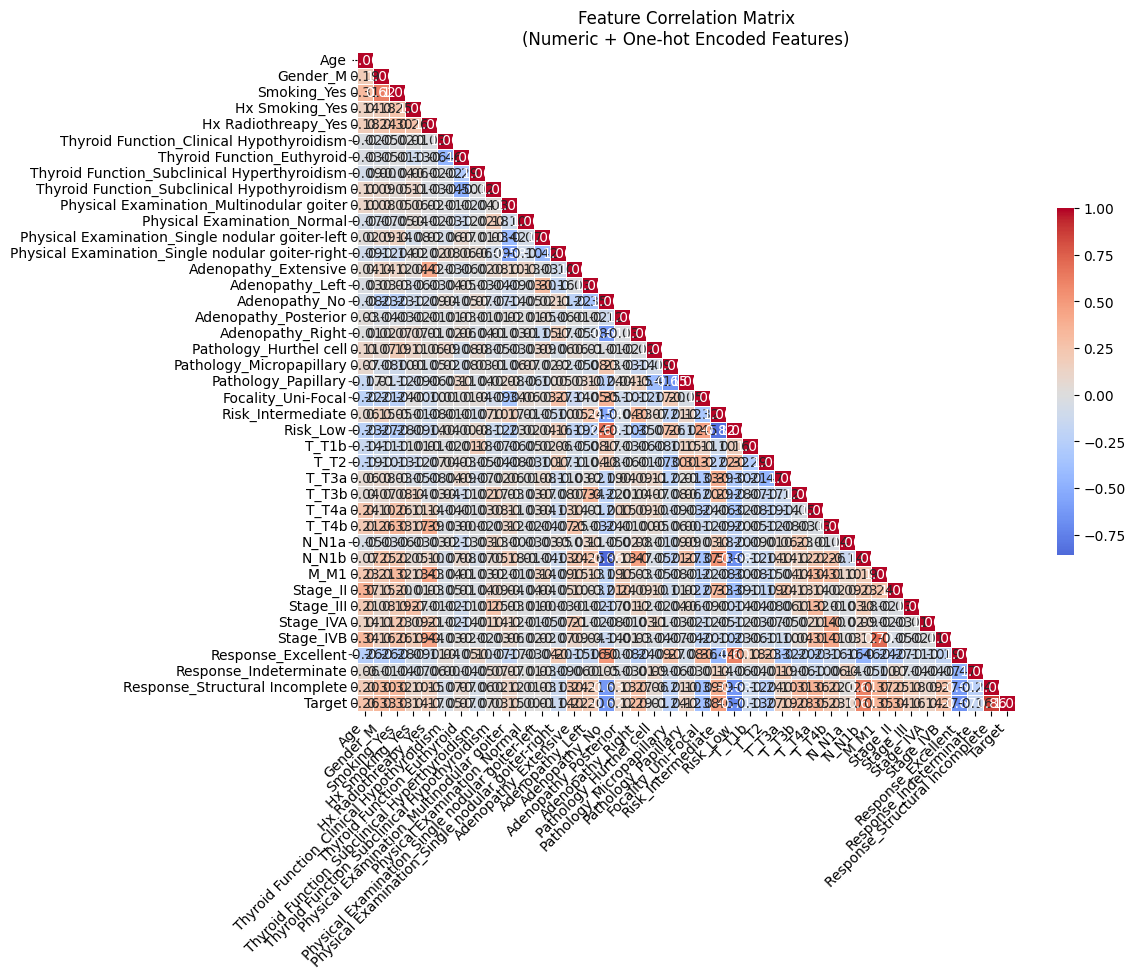


Top absolute correlations with target:
Response_Structural Incomplete    0.864
Risk_Low                          0.708
Response_Excellent                0.672
Adenopathy_No                     0.624
N_N1b                             0.606
Risk_Intermediate                 0.463
Focality_Uni-Focal                0.384
M_M1                              0.354
T_T4a                             0.348
Stage_II                          0.335
Name: Target, dtype: float64


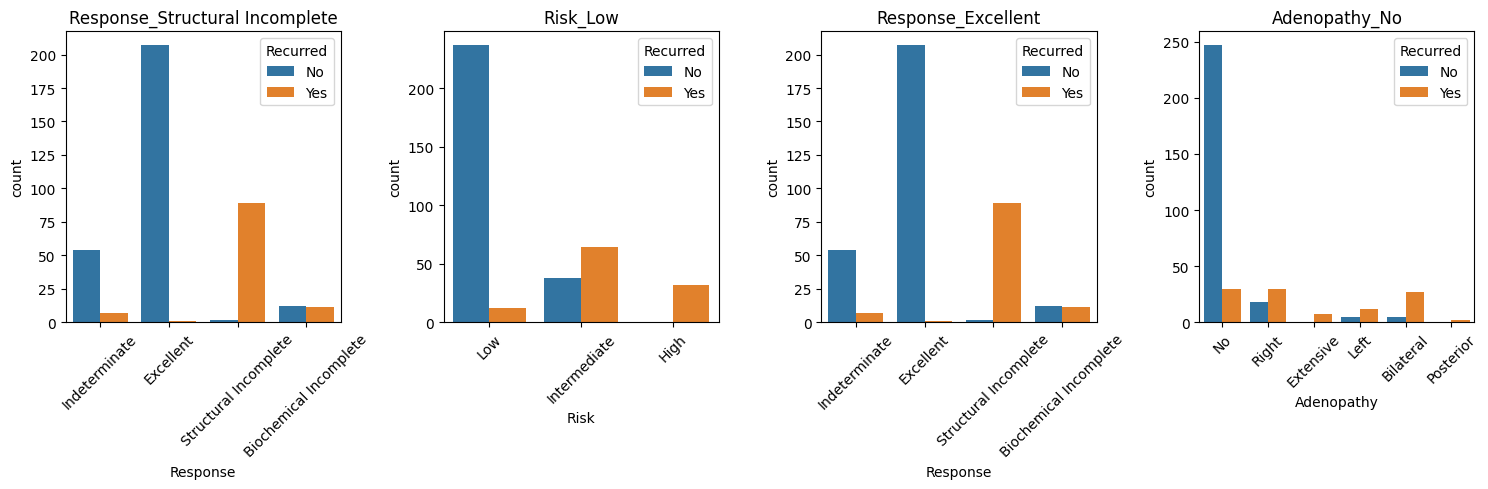

In [7]:
# Correlation heatmap for numeric and encoded features
TARGET = "Recurred"

# 1. Prepare numeric features
numeric_features = ['Age']  # Add other numeric features if needed
df_numeric = df[numeric_features]

# 2. Prepare categorical features
cat_features = [col for col in df.columns if col not in numeric_features + [TARGET]]
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
X_cat_ohe = ohe.fit_transform(df[cat_features])
ohe_feature_names = ohe.get_feature_names_out(cat_features)
df_ohe = pd.DataFrame(X_cat_ohe, columns=ohe_feature_names, index=df.index)

# 3. Add target encoding
df_ohe['Target'] = (df[TARGET] == 'Yes').astype(int)

# 4. Combine numeric and encoded features
combined_data = pd.concat([df_numeric, df_ohe], axis=1)

# 5. Calculate correlation matrix
combined_corr = combined_data.corr().round(3)

# 6. Plot correlation heatmap
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(combined_corr), k=1)  # mask upper triangle
sns.heatmap(combined_corr, 
            mask=mask,
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt='.2f',
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5})
plt.title('Feature Correlation Matrix\n(Numeric + One-hot Encoded Features)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 7. Show top correlations with target
target_correlations = combined_corr['Target'].drop('Target').abs().sort_values(ascending=False)
print("\nTop absolute correlations with target:")
print(target_correlations.head(10))

# 8. Violin plots for top correlated features
plt.figure(figsize=(15, 5))
top_features = target_correlations.head(4).index
for i, feature in enumerate(top_features, 1):
    plt.subplot(1, 4, i)
    if feature in numeric_features:
        sns.violinplot(data=df, x=TARGET, y=feature)
    else:
        # For encoded features, plot the original categorical feature
        orig_feature = feature.split('_')[0]
        if orig_feature in df.columns:
            sns.countplot(data=df, x=orig_feature, hue=TARGET)
            plt.xticks(rotation=45)
    plt.title(f'{feature}')
plt.tight_layout()
plt.show()

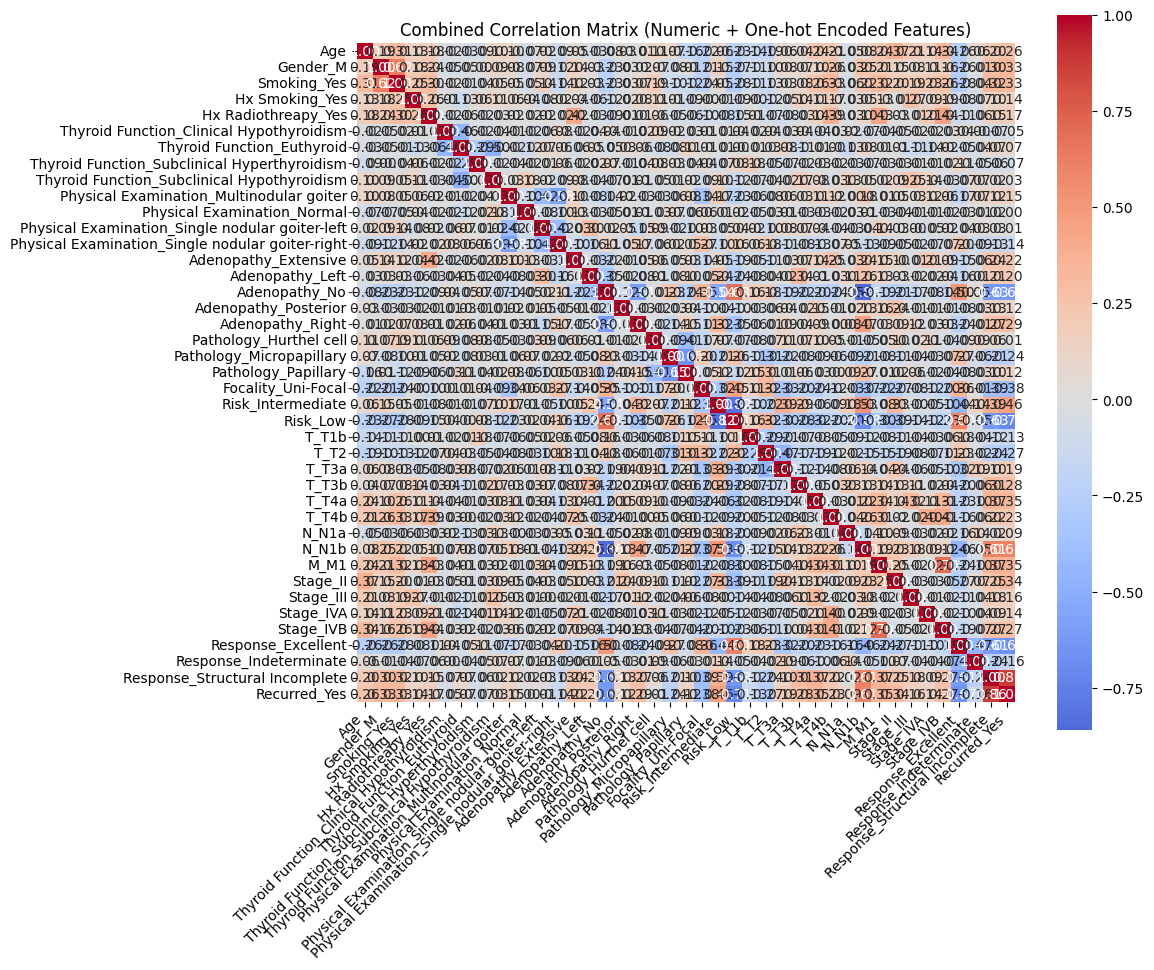


Top correlations with target (Recurred_Yes):
Recurred_Yes                      1.000000
Response_Structural Incomplete    0.863540
N_N1b                             0.605927
Risk_Intermediate                 0.462566
M_M1                              0.354360
T_T4a                             0.348473
Stage_II                          0.335022
Smoking_Yes                       0.333243
Gender_M                          0.328189
Adenopathy_Right                  0.288558
Name: Recurred_Yes, dtype: float64


In [8]:
# Calculate combined correlations (numeric + one-hot encoded features)
# First, prepare numeric features
numeric_features = ['Age']  # add other numeric features if available
df_numeric = df[numeric_features]

# Then, prepare categorical features with one-hot encoding
categorical_features = [c for c in df.columns if c not in numeric_features + [TARGET]]
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
X_cat_ohe = ohe.fit_transform(df[categorical_features])
ohe_names = ohe.get_feature_names_out(categorical_features)
df_ohe = pd.DataFrame(X_cat_ohe, columns=ohe_names, index=df.index)

# Add target encoding
df_ohe['Recurred_Yes'] = (df[TARGET] == 'Yes').astype(int)

# Combine numeric and encoded features
combined_data = pd.concat([df_numeric, df_ohe], axis=1)

# Calculate correlation matrix
combined_corr = combined_data.corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(combined_corr, 
            annot=True,  # Show correlation values
            cmap='coolwarm',  # Color scheme
            center=0,  # Center the colormap at 0
            fmt='.2f',  # Format for correlation values
            square=True)  # Make the plot square
plt.title('Combined Correlation Matrix (Numeric + One-hot Encoded Features)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Show top correlations with target
target_correlations = combined_corr['Recurred_Yes'].sort_values(ascending=False)
print("\nTop correlations with target (Recurred_Yes):")
print(target_correlations.head(10))

Top feature correlations with target:
Response_Structural Incomplete    0.863540
Risk_Low                          0.708266
Response_Excellent                0.671568
Adenopathy_No                     0.623965
N_N1b                             0.605927
Risk_Intermediate                 0.462566
Focality_Uni-Focal                0.383776
M_M1                              0.354360
T_T4a                             0.348473
Stage_II                          0.335022
dtype: float64


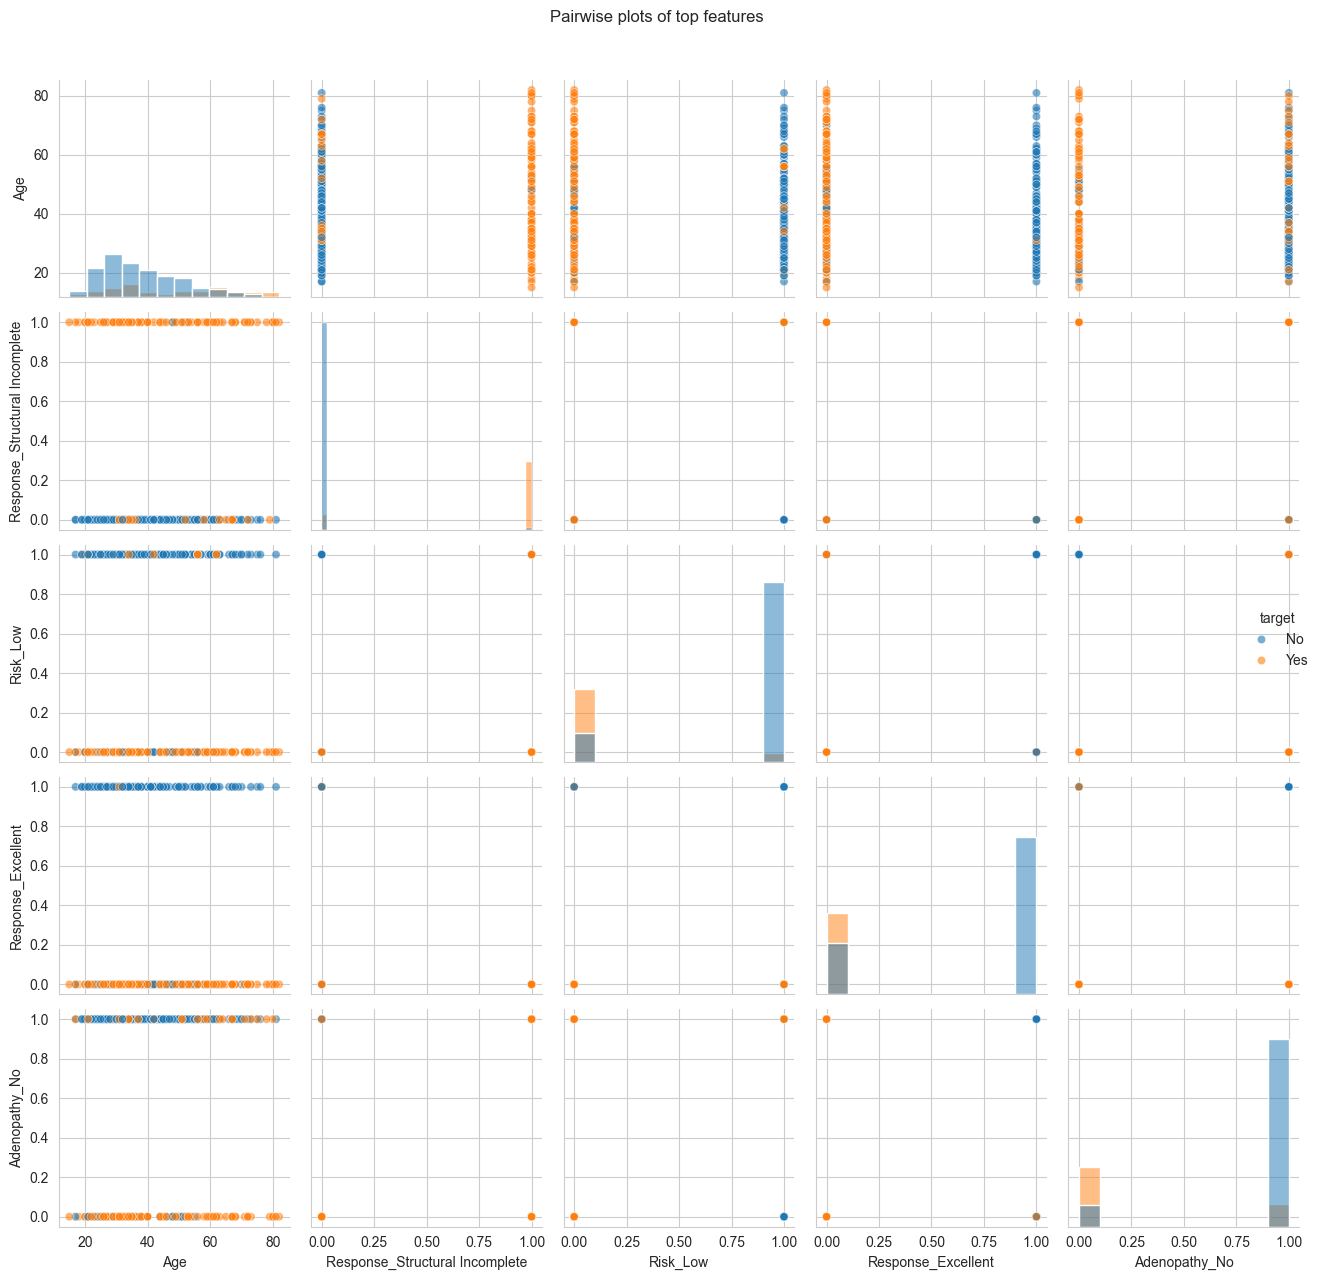


Feature descriptions:
Age: Numeric feature
Response_Structural Incomplete: Encoded category from Response
Risk_Low: Encoded category from Risk
Response_Excellent: Encoded category from Response
Adenopathy_No: Encoded category from Adenopathy


In [9]:
# Pairwise plots for top numeric features vs target
# First, prepare the data properly
TARGET = "Recurred"

# 1. Prepare numeric features
numeric_features = ['Age']  # start with Age, add other numeric features if needed

# 2. Prepare categorical features with one-hot encoding
cat_features = [col for col in df.columns if col not in numeric_features + [TARGET]]
ohe = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')
X_cat_ohe = ohe.fit_transform(df[cat_features])
ohe_feature_names = ohe.get_feature_names_out(cat_features)
df_ohe = pd.DataFrame(X_cat_ohe, columns=ohe_feature_names, index=df.index)

# 3. Calculate correlations with target
# First, create binary target
target_binary = (df[TARGET] == 'Yes').astype(int)

# Combine all features
all_features = pd.concat([
    df[numeric_features],
    df_ohe
], axis=1)

# Calculate correlations with target
correlations = pd.Series({
    col: all_features[col].corr(target_binary)
    for col in all_features.columns
}).abs().sort_values(ascending=False)

print("Top feature correlations with target:")
print(correlations.head(10))

# 4. Select top features for visualization
top_features = correlations.head(5).index.tolist()
if 'Age' not in top_features:  # ensure Age is included
    top_features = ['Age'] + top_features[:4]

# 5. Create sample DataFrame with selected features and target
plot_data = pd.concat([
    all_features[top_features],
    pd.Series(df[TARGET], name='target')
], axis=1)

# 6. Create pairplot with reduced sample size if needed
if len(plot_data) > 500:  # limit sample size for better visualization
    plot_data = plot_data.sample(n=500, random_state=42)

# Create the pairplot
sns.set_style("whitegrid")
g = sns.pairplot(
    plot_data,
    hue='target',
    diag_kind='hist',
    plot_kws={'alpha': 0.6},
    height=2.5  # control subplot size
)
g.fig.suptitle('Pairwise plots of top features', y=1.02)
plt.tight_layout()
plt.show()

# Print feature descriptions
print("\nFeature descriptions:")
for feature in top_features:
    if feature in numeric_features:
        print(f"{feature}: Numeric feature")
    else:
        # Extract original feature name from one-hot encoded column
        orig_feature = feature.split('_')[0]
        print(f"{feature}: Encoded category from {orig_feature}")

## Pearson Correlation Heatmap
We compute the correlation matrix of numerical variables and present an annotated heatmap.


In [10]:

# Pearson Correlation Heatmap
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Automatically detect the main DataFrame (adjust if needed)
possible_df_names = ['df','data','dataset','df_model','X']
_df = None
for _name in possible_df_names:
    if _name in globals():
        obj = globals()[_name]
        if isinstance(obj, pd.DataFrame):
            _df = obj
            break
if _df is None:
    try:
        _df = df
    except NameError:
        raise RuntimeError("Define your DataFrame as 'df' (or adjust this block).")

num_df = _df.select_dtypes(include=['number']).copy()
if num_df.shape[1] < 2:
    _df = pd.get_dummies(_df, drop_first=True)
    num_df = _df.select_dtypes(include=['number']).copy()
if num_df.shape[1] < 2:
    print("Warning: Fewer than 2 numeric columns for correlation, heatmap omitted.")
corr = num_df.corr(method='pearson')

if num_df.shape[1] < 2:
    pass
else:
    plt.figure(figsize=(12,9))
    sns.heatmap(corr, annot=True, fmt=".2f", square=True)
    plt.title("Correlation Matrix (Pearson) - Numerical Variables")
    plt.tight_layout()
    plt.show()


### Train/Test Split
We split the data (70–80% train and 20–30% test) to evaluate generalization.


In [11]:

y = df[TARGET_NAME]
X = df.drop(columns=[TARGET_NAME])

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric:", num_cols[:12])
print("Categorical:", cat_cols[:12])

ttype = type_of_target(y)
strat = y if ttype in ("binary","multiclass") else None

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=strat
)
X_train.shape, X_test.shape, ttype


Numeric: ['Age']
Categorical: ['Smoking', 'Hx Smoking', 'Hx Radiothreapy', 'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology', 'Focality', 'Risk', 'T', 'N', 'M']


((306, 16), (77, 16), 'binary')

### Imports and Setup
We load libraries used for EDA, preprocessing, and modeling.


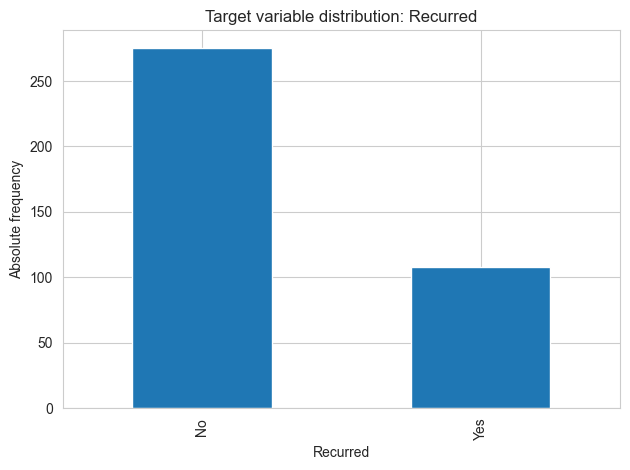

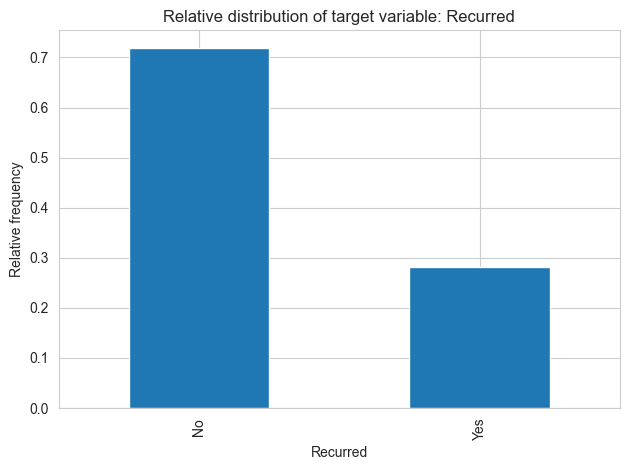

Absolute frequency:


,count
Recurred,
No,275
Yes,108


Relative frequency:


,proportion
Recurred,
No,0.718
Yes,0.282


In [12]:

# --- Distribution plot for 'recurred' (or detected target) ---
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Try preferred column name(s) first; otherwise fall back to TARGET_NAME
preferred_names = ["recurred", "Recurrence", "recurrence", "recur", "Recurred"]
target_col = None

# If a dataframe 'df' exists, figure out which column to plot
try:
    if isinstance(df, pd.DataFrame):
        for cand in preferred_names:
            if cand in df.columns:
                target_col = cand
                break
        if target_col is None:
            # fall back to TARGET_NAME if defined and present in df
            try:
                if 'TARGET_NAME' in globals() and TARGET_NAME in df.columns:
                    target_col = TARGET_NAME
            except Exception:
                pass
except NameError:
    pass

if target_col is None:
    raise RuntimeError(
        "Não encontrei a coluna 'recurred'. Certifique-se de que a base foi carregada em 'df' "
        "e que a coluna alvo ('recurred' ou TARGET_NAME) existe."
    )

vc = df[target_col].value_counts(dropna=False).sort_index()
vc_norm = (vc / vc.sum()).round(4)

plt.figure()
vc.plot(kind="bar")
plt.title(f"Target variable distribution: {target_col}")
plt.xlabel(target_col)
plt.ylabel("Absolute frequency")
plt.tight_layout()
plt.show()

# Relative frequency (in another figure, still 1 per plot)
plt.figure()
vc_norm.plot(kind="bar")
plt.title(f"Relative distribution of target variable: {target_col}")
plt.xlabel(target_col)
plt.ylabel("Relative frequency")
plt.tight_layout()
plt.show()

print("Absolute frequency:")
display(vc.to_frame(name="count"))
print("Relative frequency:")
display(vc_norm.to_frame(name="proportion"))



**Inferences from the plot(s):**
- Observe central tendency and possible outliers.
- Check relationships with the target variable (clear differences between classes).
- Identify variables with patterns that may influence the model.


### Preprocessing
Variable encoding, normalization/standardization, and pipeline assembly.


In [13]:

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler(with_mean=True))
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])
preprocess = ColumnTransformer(
    transformers=[('num', numeric_transformer, num_cols),
                  ('cat', categorical_transformer, cat_cols)],
    remainder='drop'
)
preprocess


,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'median'
,fill_value,None


### Preprocessing
Variable encoding, normalization/standardization, and pipeline assembly.


In [14]:

models = {}
models['Logistic Regression'] = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(random_state=42, max_iter=2000, multi_class='ovr'))
])
models['Random Forest'] = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1))
])
if XGB_AVAILABLE:
    models['XGBoost'] = Pipeline(steps=[
        ('prep', preprocess),
        ('clf', XGBClassifier(random_state=42, n_estimators=500, learning_rate=0.05,
                              max_depth=4, subsample=0.9, colsample_bytree=0.9,
                              reg_lambda=1.0, eval_metric='mlogloss', tree_method='hist',
                              use_label_encoder=False, n_jobs=-1))
    ])
else:
    models['Gradient Boosting (fallback)'] = Pipeline(steps=[
        ('prep', preprocess),
        ('clf', GradientBoostingClassifier(random_state=42))
    ])
list(models.keys())


['Logistic Regression', 'Random Forest', 'XGBoost']

### Imports and Setup
We load libraries used for EDA, preprocessing, and modeling.


In [15]:

def compute_metrics(y_true, y_pred, y_proba=None, average='weighted'):
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=average, zero_division=0)
    rec  = recall_score(y_true, y_pred, average=average, zero_division=0)
    f1   = f1_score(y_true, y_pred, average=average, zero_division=0)
    auc_val = np.nan
    ttype = type_of_target(y_true)
    if y_proba is not None:
        try:
            if ttype == 'binary':
                if y_proba.ndim == 2 and y_proba.shape[1] > 1:
                    proba_pos = y_proba[:, 1]
                else:
                    proba_pos = y_proba.ravel()
                auc_val = roc_auc_score(y_true, proba_pos)
            elif ttype == 'multiclass':
                auc_val = roc_auc_score(y_true, y_proba, multi_class='ovr', average='weighted')
        except Exception:
            pass
    return acc, prec, rec, f1, auc_val

# Model ranking (adjust order to your preference)
# Default: F1 > Accuracy > ROC-AUC (weighted)
RANK_ORDER = ['f1', 'accuracy', 'roc_auc_weighted']


results = []
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    y_proba = None
    clf = pipe.named_steps['clf']
    try:
        if hasattr(clf, "predict_proba"):
            y_proba = pipe.predict_proba(X_test)
        elif hasattr(clf, "decision_function"):
            from sklearn.preprocessing import MinMaxScaler
            s = pipe.decision_function(X_test)
            if s.ndim == 1:
                s = s.reshape(-1, 1)
            y_proba = MinMaxScaler().fit_transform(s)
    except Exception:
        y_proba = None

    acc, prec, rec, f1, auc_val = compute_metrics(y_test, y_pred, y_proba, average='weighted')
    results.append({'model': name, 'accuracy': acc, 'precision': prec, 'recall': rec, 'f1': f1, 'roc_auc_weighted': auc_val})

results_df = pd.DataFrame(results).sort_values(by=RANK_ORDER, ascending=False).reset_index(drop=True)
# Add a column marking the top row (best model)
if len(results_df) > 0:
    best_flags = [''] * len(results_df)
    best_flags[0] = '*'
    results_df.insert(0, 'best', best_flags)
results_df


c:\Users\romil\anaconda3\envs\envproj2\Lib\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1], got ['F' 'M']

## Cross-Validation (k-fold)
We apply StratifiedKFold with `cross_validate` to estimate average performance and variability of the models.


In [ ]:

# Stratified cross-validation with cross_validate
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

# Heuristic to obtain X and y automatically
# Tente usar X,y se já existirem
try:
    X  # noqa
    y  # noqa
except NameError:
    # Caso não existam, tentamos obtê-los a partir de um DataFrame df
    if 'df' not in globals():
        raise RuntimeError("Define X,y or provide a DataFrame 'df' with the target column before this block.")
    _df = df.copy()
    # Binary target heuristic
    target_candidates = [c for c in _df.columns if _df[c].nunique() in (2,3) and c.lower() in ('target','class','outcome','label','diagnosis','thyroid','recurred','recurrence')]
    if not target_candidates:
        # fallback: smallest cardinality > 1
        cardinalities = sorted([(c, _df[c].nunique()) for c in _df.columns if _df[c].nunique()>1], key=lambda x:x[1])
        if not cardinalities:
            raise RuntimeError("Could not infer the target variable. Define y explicitly.")
        target_candidates = [cardinalities[0][0]]
    y_name = target_candidates[0]
    y = _df[y_name]
    X = _df.drop(columns=[y_name]).select_dtypes(include=['number']).copy()
    if X.shape[1] == 0:
        raise RuntimeError("X ended up with no numeric columns. Adjust the preprocessing.")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
model = Pipeline(steps=[
    ('prep', preprocess),
    ('clf', LogisticRegression(max_iter=1000))
])

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, average='binary'),
}
# AUC only if probabilities are available and the target is binary with {0,1}
try:
    scoring['roc_auc'] = 'roc_auc'
except Exception:
    pass

cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=False)
summary = {k: (np.mean(v), np.std(v)) for k,v in cv_results.items() if k.startswith('test_')}
print("Mean ± std (5-fold):")
for k,(m,s) in summary.items():
    print(f"  {k.replace('test_','')}: {m:.4f} ± {s:.4f}")


### Model Evaluation
We evaluate performance with metrics appropriate for the task.


In [ ]:

for name, pipe in models.items():
    print("="*70)
    print(name)
    y_pred = pipe.predict(X_test)
    print(classification_report(y_test, y_pred, digits=4))


### Model Evaluation
We evaluate performance with metrics appropriate for the task.


In [ ]:

labels = np.unique(y_test)
for name, pipe in models.items():
    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    plt.figure(figsize=(5,4))
    plt.imshow(cm)
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha='center', va='center')
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45)
    plt.yticks(ticks=range(len(labels)), labels=labels)
    plt.colorbar(); plt.tight_layout(); plt.show()



**Inferences from the plot(s):**
- Observe central tendency and possible outliers.
- Check relationships with the target variable (clear differences between classes).
- Identify variables with patterns that may influence the model.


### Imports and Setup
We load libraries used for EDA, preprocessing, and modeling.


In [ ]:

from sklearn.preprocessing import label_binarize

ttype = type_of_target(y_test)
if ttype == 'binary':
    plt.figure(figsize=(6,5))
    for name, pipe in models.items():
        try:
            if hasattr(pipe.named_steps['clf'], "predict_proba"):
                y_proba = pipe.predict_proba(X_test)[:, 1]
            elif hasattr(pipe.named_steps['clf'], "decision_function"):
                from sklearn.preprocessing import MinMaxScaler
                s = pipe.decision_function(X_test).reshape(-1,1)
                y_proba = MinMaxScaler().fit_transform(s).ravel()
            else:
                y_proba = None
            if y_proba is None:
                continue
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            plt.plot(fpr, tpr, label=name)
        except Exception:
            continue
    plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC (Binary)")
    plt.legend(); plt.tight_layout(); plt.show()
elif ttype == 'multiclass':
    classes = np.unique(y_test)
    for name, pipe in models.items():
        try:
            if hasattr(pipe.named_steps['clf'], "predict_proba"):
                y_proba = pipe.predict_proba(X_test)
            elif hasattr(pipe.named_steps['clf'], "decision_function"):
                from sklearn.preprocessing import MinMaxScaler
                s = pipe.decision_function(X_test)
                if s.ndim == 1: s = s.reshape(-1,1)
                y_proba = MinMaxScaler().fit_transform(s)
            else:
                y_proba = None
            if y_proba is None:
                continue
            y_bin = label_binarize(y_test, classes=classes)
            plt.figure(figsize=(6,5))
            for i, cls in enumerate(classes):
                fpr, tpr, _ = roc_curve(y_bin[:, i], y_proba[:, i])
                plt.plot(fpr, tpr, label=f"Class {cls}")
            plt.plot([0,1],[0,1],'--'); plt.xlabel("FPR"); plt.ylabel("TPR")
            plt.title(f"ROC (OVR) – {name}"); plt.legend(); plt.tight_layout(); plt.show()
        except Exception:
            continue



**Inferences from the plot(s):**
- Observe central tendency and possible outliers.
- Check relationships with the target variable (clear differences between classes).
- Identify variables with patterns that may influence the model.


### Intermediate Step
We executed a necessary step for the analysis/modeling sequence.


In [ ]:

out_csv = "outputs/predictThyroid_model_report.csv"
results_df.to_csv(out_csv, index=False)
print(f"Report saved to: {out_csv}")
results_df
